# Classification

This notebook builds and compares several different classifiers for a simple dataset - the unit square with classes separated by $y=x^2$. It shows the effect of training set size on the decision boundaries found, and how rapidly the different classifiers learn from the data. 

It looks at accuracy, precision, recall, F1, F1 Weighted, and the Matthews Correlation Coefficient (MCC).

Note: scikit-learn added a **Multilayer Perceptron**/Neural Network to version 0.18 - you can install version 0.18 in a separate conda environment, and start the Jupyter notebook from that environment to see the results from that classifier also (it actually turns out to be the best). 

## Imports

In [1]:
# allow inline plots
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import math
import time

## Parameters

In [2]:
seed = 0
np.random.seed(seed)
colormap = mpl.cm.get_cmap('RdYlGn') # default colormap for plots

## Get data

In [3]:
# define a simple function with 2 features and a label
# the dividing line between the labels is just y=x^2

def f(x):
    "decision boundary function"
    return x*x

def flabel(x,y):
    "label function - class 1 is above decision boundary, class 0 below"
    return int(y>f(x))

# define domain
fxmin = 0.0
fxmax = 1.0
fymin = 0.0
fymax = 1.0

In [4]:
# define a sampling function

def getSamples(nsamples):
    "get random sample of points in domain and assign labels (0 or 1)"
    xs = np.random.rand(nsamples) * (fxmax-fxmin) + fxmin
    ys = np.random.rand(nsamples) * (fymax-fymin) + fymin

    labels = [flabel(x,y) for x,y in zip(xs,ys)]

    # make a pandas dataframe with x,y,label
    data = pd.DataFrame({'x':xs,'y':ys,'label':labels})

    return data

In [5]:
nsamples = 250
data = getSamples(nsamples)
print data.sample(5)

     label         x         y
82       1  0.064147  0.056848
137      0  0.653201  0.159414
44       1  0.666767  0.511319
14       1  0.071036  0.669917
104      1  0.248753  0.536177


## Preprocess data

In [6]:
# split data into features (X) and outcomes (y),
# which is how sklearn prefers to deal with the data.
X = data[['x','y']]
y = data['label']

## Show data

In [7]:
def plotData(X, y, xaxis='x', yaxis='y'):
    "plot 2d classification data"

    # split data into positive/negative samples
    positive = X[y==1]
    negative = X[y==0]

    plt.figure(figsize=(3,3))
    plt.scatter(positive[xaxis],positive[yaxis],color='g',label='positive')
    plt.scatter(negative[xaxis],negative[yaxis],color='r',label='negative')
    plt.xlabel(xaxis)
    plt.ylabel(yaxis)
    xs = np.arange(fxmin, fxmax+0.1, 0.1)
    ys = f(xs)
    plt.plot(xs,ys,label='decision boundary')
    plt.xlim(fxmin-0.1,fxmax+0.1)
    plt.ylim(fymin-0.1,fymax+0.1)
    plt.grid()
    plt.legend(bbox_to_anchor=(2, 1))
    plt.title('Sample data and actual decision boundary')
    plt.show()

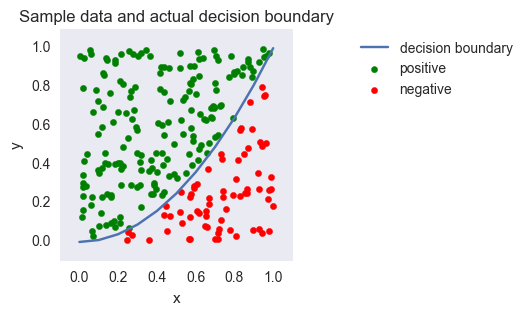

In [8]:
plotData(X, y)

## Simplest possible model

In [9]:
# the simplest model we could make from this dataset would be to 
# choose the most likely value.

def mode(a):
    "return the mode of the given list or array of integer values"
    bincounts = np.bincount(a) # eg [41 59] - ie 49 0's and 59 1's
    mode = bincounts.argmax() # index of highest value, eg 1
    return mode

most_likely_value = mode(y)
print 'most likely value', most_likely_value

predictions = [most_likely_value] * nsamples # eg [0,0,0...]

# get an array of booleans
results = (data['label'] == predictions)

# you can actually take the mean of an array of booleans
accuracy = results.mean() 
print 'accuracy',accuracy

# that the accuracy we get here is the baseline that we need to improve on.

most likely value 1
accuracy 0.72


## Train a classifier

In [10]:
# now let's train a classifier on the data to get a model, 
# and use the model to make predictions.

# 1. import the classifier
from sklearn.tree import DecisionTreeClassifier

# 2. instantiate the classifier
clf_tree = DecisionTreeClassifier()

# 3. fit the data (first let's try fitting on ALL the data)
clf_tree.fit(X, y)

# 4. make a prediction
label = clf_tree.predict([[0.5,0.5]])
print label

[1]


In [11]:
# but we don't have any idea how well it's performing!

## Test/train split

In [12]:
# so let's train it on part of the data and test it on the other part.

from sklearn.cross_validation import train_test_split

# note test_size=20%, so will train on 80% of records
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

c:\Anaconda\envs\sklearn018\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [13]:
# now train the classifier on the training data
clf_tree.fit(X_train, y_train)

# make predictions on the test data
y_predict = clf_tree.predict(X_test)

# show some results
print 'actual   ',list(y_test[:20])
print 'predicted',list(y_predict[:20])

actual    [0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1]
predicted [0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]


In [14]:
# let's see if we can visualize what's going on...

## Get accuracy

In [15]:
# get an accuracy score
accuracy = (y_test==y_predict).mean()
print 'accuracy (test)',accuracy

# you can also use the score method on the classifier to get the score,
# which for this classifier is the accuracy.
# see http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
#      #sklearn.tree.DecisionTreeClassifier.score
print 'accuracy (test)',clf_tree.score(X_test, y_test)

accuracy (test) 0.94
accuracy (test) 0.94


In [16]:
# so what about the training accuracy?
# ie how well does the model do against the training data that it was trained with?
print 'training accuracy',clf_tree.score(X_train, y_train)

training accuracy 1.0


In [17]:
# note that we didn't tell the decision tree what depth to use, 
# so it probably went as far as it could,
# hence should have a high training accuracy (towards 100%)

# q. since the training accuracy is so high, would you say this has high variance?
# yes, i.e. it's in the regime of overfitting - the model complexity 
# needs to be reduced in order to improve the performance of the classifier.

## Visualize the model

In [18]:
def plotDataAndModel(X, y, clf=None, title=None, xaxis='x', yaxis='y'):
    "Plot given data points and fill in background with classifier predictions"

    # fill in background with classifier predictions
    if clf:
        h = 0.025 # grid spacing

        # assign a color to each point in the mesh.
        # note: np.c_ concatenates arrays, ravel flattens 2d arrays to 1d. 
        xs = np.arange(fxmin, fxmax+h, h)
        ys = np.arange(fymin, fymax+h, h)
        xgrid, ygrid = np.meshgrid(xs, ys) # get 11x11 arrays
        grid_points = np.c_[xgrid.ravel(), ygrid.ravel()] # 121x2 array

        np.random.seed(seed)
        
        # get 2x2 array of labels or probabilities
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(grid_points)
            Z = np.where(Z>0,1,-1)
        else:
            Z = clf.predict_proba(grid_points)[:, 1]
            Z = np.where(Z>0.5,1,-1)

        # convert Z to a 2d array    
        Z = Z.reshape(xgrid.shape) 
        
        # draw the decision regions
        #plt.contourf(xs, ys, Z, cmap=colormap, alpha=0.7)   
        plt.contour(xs, ys, Z, levels=[.5], cmap="Greys", vmin=-1, vmax=1)        
    
    # draw the sample points
    # note: lw=0 prevents drawing black line around each circle
    xs = X[xaxis]
    ys = X[yaxis]
    plt.scatter(xs, ys, c=y, cmap=colormap, lw=0.0) 
    if title:
        plt.title(title)

accuracy 0.94


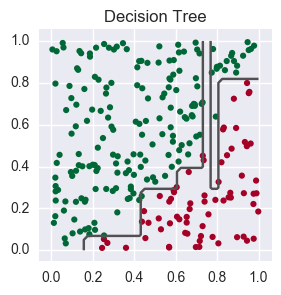

In [19]:
# plot the test points and the learned decision boundary
plt.figure(figsize=(3,3))
plotDataAndModel(X, y, clf_tree, 'Decision Tree')
print 'accuracy', clf_tree.score(X_test, y_test)

In [20]:
# note how jagged the border is - decision trees can overfit to the training data,
# causing them to not generalize well to the test data or to real world data.

## Comparing classifiers

In [48]:
# import and create classifiers
from sklearn.dummy          import DummyClassifier
from sklearn.linear_model   import LogisticRegression
from sklearn.neighbors      import KNeighborsClassifier
from sklearn.tree           import DecisionTreeClassifier
from sklearn.svm            import SVC
from sklearn.ensemble       import RandomForestClassifier
from sklearn.ensemble       import GradientBoostingClassifier
from sklearn.ensemble       import AdaBoostClassifier
from sklearn.naive_bayes    import GaussianNB
from sklearn.linear_model   import Perceptron

from collections import OrderedDict
classifier_list = [
    ['Baseline',              DummyClassifier(strategy='most_frequent')],
    ['Logistic Regression',   LogisticRegression(random_state=seed)],
    ['Gaussian Naive Bayes',  GaussianNB()], # no random_state
    ['SVM (Linear)',          SVC(kernel='linear',random_state=seed)],
#    ['SVM (Polynomial)',      SVC(kernel='poly',random_state=seed)], # does poorly
    ['SVM (Gaussian)',        SVC(kernel='rbf',random_state=seed)], # rbf is the default kernel
    ['K-Nearest Neighbors',   KNeighborsClassifier()], # no random_state
    ['Decision Tree',         DecisionTreeClassifier(random_state=seed)],
    ['Random Forest',         RandomForestClassifier(random_state=seed)],
    ['Gradient Boosting',     GradientBoostingClassifier(random_state=seed)],
    ['AdaBoost',              AdaBoostClassifier(random_state=seed)],
    ['Perceptron',            Perceptron(random_state=seed, n_iter=50)],
]

# multi layer perceptron is available in sklearn version 0.18
try:
    from sklearn.neural_network import MLPClassifier # Multi Layer Perceptron
    classifier_list.append( \
        ['Multilayer Perceptron', MLPClassifier(solver='lbfgs',random_state=seed)])
except:
    print "Multilayer Perceptron not available"

classifiers = OrderedDict(classifier_list)

In [49]:
# test the baseline classifier - should be all 1's
baseline = classifiers['Baseline']
baseline.fit(X_train, y_train)
print baseline.predict(X_test)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [50]:
# import metrics
# includes accuracy, precision, f1, confusion_matrix, etc
from sklearn import metrics

In [51]:
# make a plot function
def compareClassifiers(classifiers, data):
    "Fit classifiers to data, display in chart, and return results as a pandas table"
    
    # split data into features (X) and outcomes (y),
    # which is how sklearn prefers to deal with the data.
    X = data[['x','y']]
    y = data['label']
    
    # split into training and test data
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=seed)
    
    fig = plt.figure(figsize=(12,9))
    rows = []
    columns = ['Classifier','Accuracy','Precision','Recall','F1','F1 weighted','MCC']
    iplot = 1
    for classifier_name, clf in classifiers.items():
    
        # train model
        clf.fit(X_train, y_train)
        
        # predict labels
        y_predict = clf.predict(X_test)
        
        # plot data
        plt.subplot(3,4,iplot)
        plotDataAndModel(X_train, y_train, clf, classifier_name)
        #plotDataAndModel(X_test, y_test, clf, classifier_name)
        iplot += 1

        # get metrics
        accuracy    = metrics.accuracy_score(y_test, y_predict)
        precision   = metrics.precision_score(y_test, y_predict)
        recall      = metrics.recall_score(y_test, y_predict)
        f1          = metrics.f1_score(y_test, y_predict)
        f1_weighted = metrics.f1_score(y_test, y_predict, average='weighted', pos_label=None)
        mcc         = metrics.matthews_corrcoef(y_test, y_predict)

        # add results to table
        row = [classifier_name, accuracy, precision, recall, f1, f1_weighted, mcc]
        rows.append(row)
        
    fig.suptitle('Decision Boundaries found by Different Classifiers for $y=x^2$', fontsize=18)
    #plt.tight_layout()
    plt.subplots_adjust(hspace=0.4)
    
    results = pd.DataFrame(rows, columns=columns)
    return results

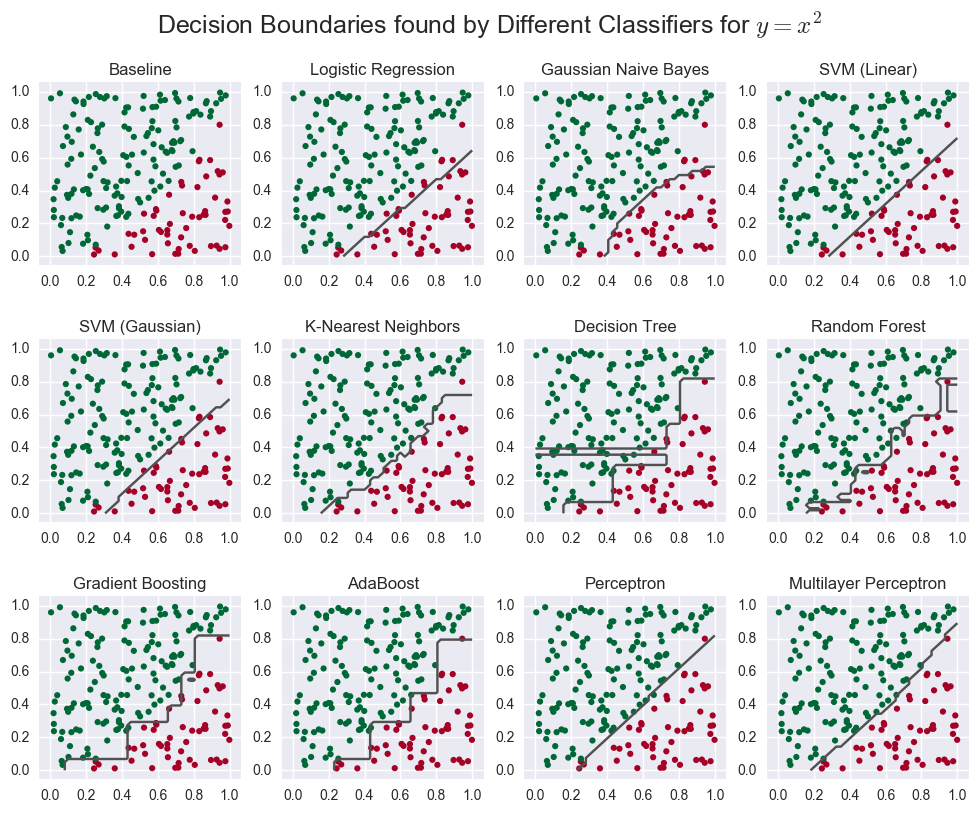

In [52]:
# show training data and decision boundaries
results = compareClassifiers(classifiers, data)

In [39]:
# note that the perceptron initially did pretty poorly but 
# increasing the number of iterations to 50 from the default 5 helped a lot

In [40]:
# show results, sorted by MCC
results.sort('MCC',ascending=False)

c:\Anaconda\envs\sklearn018\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


,Classifier,Accuracy,Precision,Recall,F1,F1 weighted,MCC
11,Multilayer Perceptron,1.00,1.000000,1.000000,1.000000,1.000000,1.000000
6,Decision Tree,0.98,0.972222,1.000000,0.985915,0.979796,0.952579
8,Gradient Boosting,0.98,0.972222,1.000000,0.985915,0.979796,0.952579
9,AdaBoost,0.98,0.972222,1.000000,0.985915,0.979796,0.952579
10,Perceptron,0.98,0.972222,1.000000,0.985915,0.979796,0.952579
5,K-Nearest Neighbors,0.94,0.921053,1.000000,0.958904,0.937900,0.858395
2,Gaussian Naive Bayes,0.92,0.897436,1.000000,0.945946,0.916008,0.811246
3,SVM (Linear),0.92,0.897436,1.000000,0.945946,0.916008,0.811246
4,SVM (Gaussian),0.92,0.897436,1.000000,0.945946,0.916008,0.811246
7,Random Forest,0.92,0.918919,0.971429,0.944444,0.918254,0.805940


So the **Multilayer Perceptron (Neural Network)** does perfectly on this very clean (no noise) data - the next best are **Decision Tree**, **Gradient Boosting**, and **AdaBoost**.

Note: **MCC** is the Matthews Correlation Coefficient, which tries to balance all four numbers of the confusion matrix. 

> The Matthews correlation coefficient is used in machine learning as a measure of the quality of binary (two-class) classifications. It takes into account true and false positives and negatives and is generally regarded as a balanced measure which can be used even if the classes are of very different sizes. The MCC is in essence a correlation coefficient value between -1 and +1. A coefficient of +1 represents a perfect prediction, 0 an average random prediction and -1 an inverse prediction.

http://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html

Note that the Baseline classifier has an MCC score of 0.0, which indicates random guessing. 

## Effect of training set size on classifiers

Now let's see what the effect training set size has on the different classifiers - we'll be able to see how quickly different classifiers learn, and how well they avoid overfitting.

In [41]:
# make a plot function
def compareClassifiers2(classifiers, sample_sizes):
    "Fit classifiers to different sizes of training data, show results in chart"

    nrows = len(classifiers)
    ncols = len(sample_sizes)
    
    fig = plt.figure(figsize=(8,32))

    for col, sample_size in enumerate(sample_sizes):
        data = getSamples(sample_size)
    
        # split data into features (X) and outcomes (y),
        # which is how sklearn prefers to deal with the data.
        X = data[['x','y']]
        y = data['label']

        # split into training and test data
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=seed)

        for row, classifier_name in enumerate(classifiers):

            clf = classifiers[classifier_name]
            
            # train model
            clf.fit(X_train, y_train)

            # predict labels
            y_predict = clf.predict(X_test)

            # plot data
            iplot = row*ncols + col + 1
            plt.subplot(nrows, ncols, iplot)
            plotDataAndModel(X_train, y_train, clf, classifier_name)
            #plotDataAndModel(X_test, y_test, clf, classifier_name)

    fig.suptitle('Decision Boundaries found for different sample sizes for $y=x^2$', fontsize=18)
    plt.subplots_adjust(top=0.95, hspace=0.4)

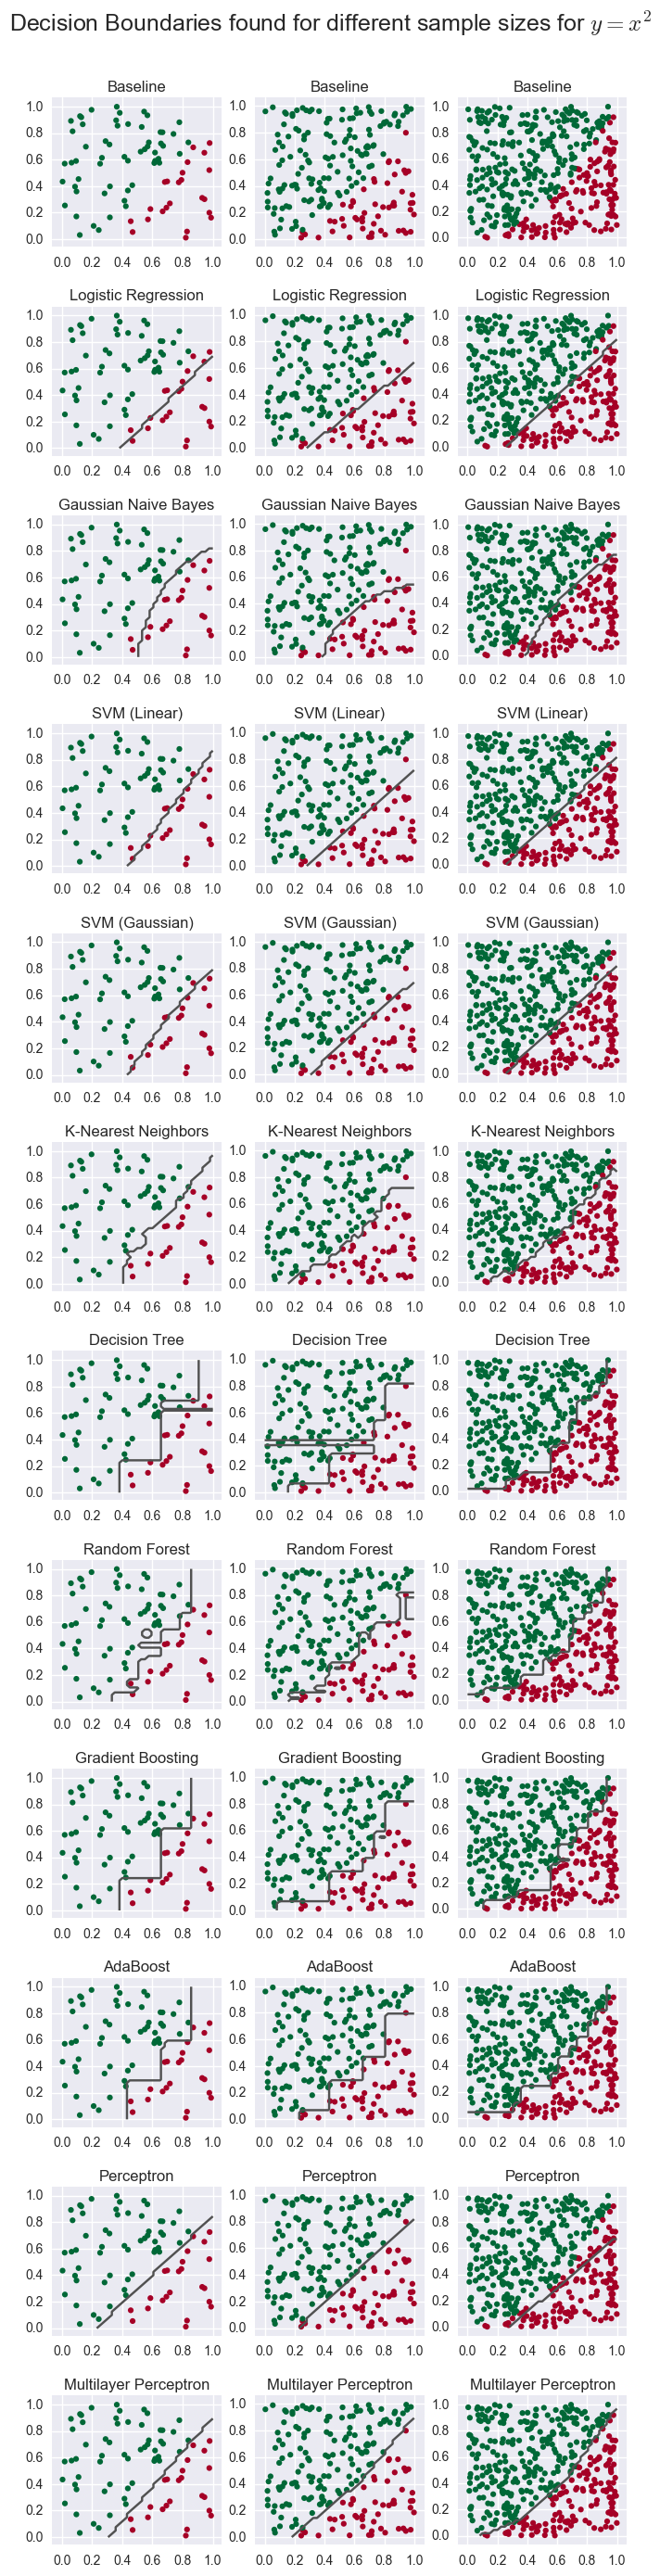

In [42]:
sample_sizes = [100,250,500]
compareClassifiers2(classifiers, sample_sizes)

In [53]:
# note how jagged the decision boundaries are for the tree-based classifiers,
# especially for small amounts of training data

## Conclusion



Of the classifiers looked at, the **Multilayer Perceptron (Neural Network)** performed best (perfectly, actually) on this simple clean/non-noisy classification problem, across all metrics. Just looking at the decision boundaries found you can see how well the neural network performed compared to the others. 

Next-best were **Decision Tree**, **Gradient Boosting**, and **AdaBoost**. This is not to say these would work best for all problems, just this one in particular. 

For the different training set size examples, you can see how poorly the tree-based classifiers do with little data - they produce jagged decision boundaries, i.e. overfit to the training data. 

To extend this experiment, you could also look at effect of noise in the data on the different classifiers, or try more non-linearity in the given classification task. 

But overall, this shows how well neural networks can do at classification. 